# Sentiment Analysis in Python

###  Employing Sentiment analysis using 2 different techniques

#### 1. VADER (Valence Aware Dictionary and Sentiment Reasoner)
#### 2. Roberta pretrained Model
#### 3. Huggingface Pipeline

In [3]:
!pip install kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d snap/amazon-fine-food-reviews

 94% 227M/242M [00:01<00:00, 186MB/s]
100% 242M/242M [00:01<00:00, 182MB/s]


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [6]:
!pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 2.8 MB/s eta 0:00:00


In [7]:
import patoolib
patoolib.extract_archive('amazon-fine-food-reviews.zip')

patool: Extracting amazon-fine-food-reviews.zip ...
patool: running /usr/bin/7z x -o./Unpack_dmkhpak2 -- amazon-fine-food-reviews.zip
patool: ... amazon-fine-food-reviews.zip extracted to `amazon-fine-food-reviews' (multiple files in root).


'amazon-fine-food-reviews'

In [8]:
df = pd.read_csv('amazon-fine-food-reviews/Reviews.csv')

In [12]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [13]:
print(df.shape)

(568454, 10)


## Quick EDA

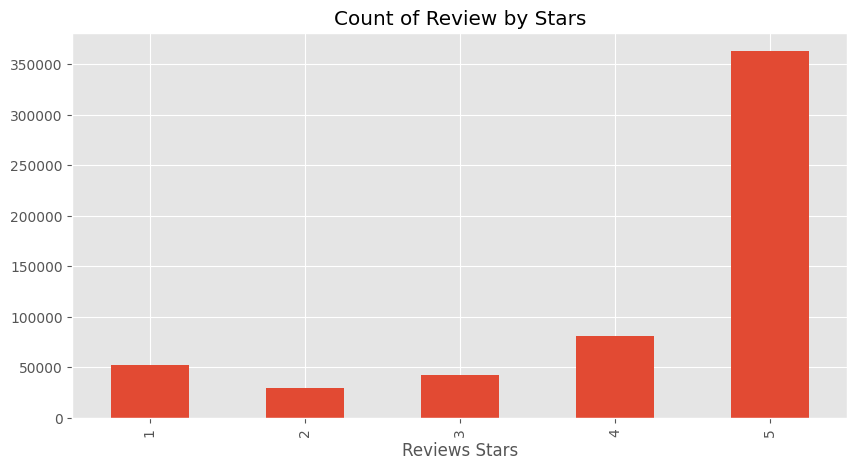

In [14]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar',
                                            title='Count of Review by Stars',
                                            figsize=(10, 5))
ax.set_xlabel('Reviews Stars')
plt.show()

## Basic NLTK

In [15]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [18]:
#nltk.download('punkt')                   # In case you face erroe uncomment these lines

tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [21]:
#nltk.download('averaged_perceptron_tagger')   #uncomment if you face nltk lookup error
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

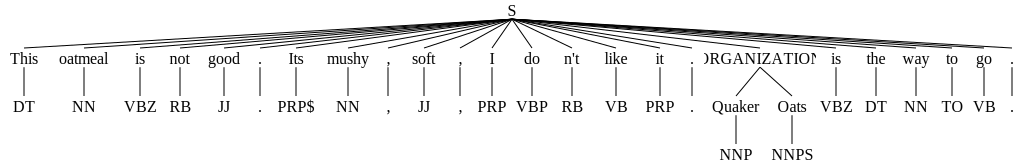

In [23]:
#nltk.download('maxent_ne_chunker')       #uncomment if you face problem
#nltk.download('words')
#!pip install svgling
nltk.chunk.ne_chunk(tagged)

In [24]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# Step 1. VADER Sentiment Scoring

#### We will use NLTK's **SentimentIntensityAnalyzer** to get the neg/neu/pos scores of the text.

#### This use a "bag of words" approach:
> 1. Stop words are removed
> 2. Each word is scored and combined to a total score.

In [25]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()
sia

In [27]:
sia.polarity_scores('I am so nervous!')

{'neg': 0.573, 'neu': 0.427, 'pos': 0.0, 'compound': -0.3989}

In [28]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [29]:
# Run the polarity on the entire dataset

res = {}    #Dictionary for storing evering Id and its text polarity
for i, row in tqdm(df.iterrows(), total= len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)


  0%|          | 0/568454 [00:00<?, ?it/s]

In [30]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [31]:
#Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER result

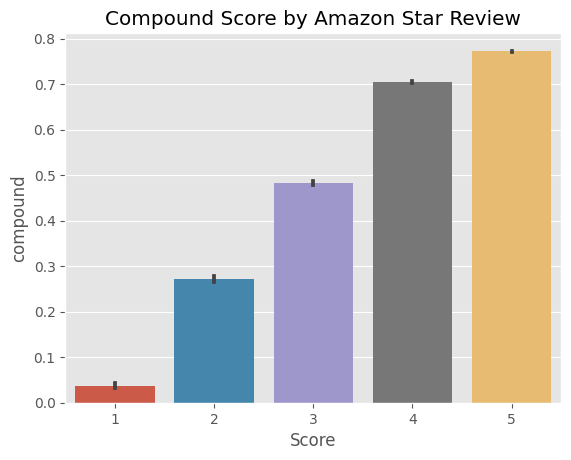

In [33]:
ax = sns.barplot(data= vaders, x= 'Score', y= 'compound')
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

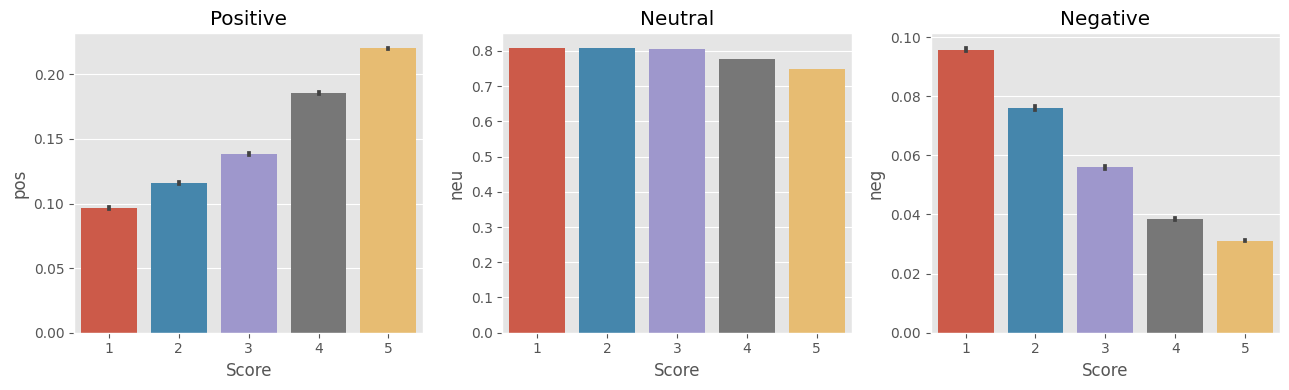

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
sns.barplot(data= vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data= vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data= vaders, x='Score', y='neg', ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model
> 1. Use a model trained of a large corpus of data
> 2. Transformer model accounts for the words but also the context related to other works

In [ ]:
!pip install transformers

In [40]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [41]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [42]:
# VADER result on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [44]:
#Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687466, 'roberta_pos': 0.0029573692}


In [45]:
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors='pt')
  output = model(**encoded_text)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
  }
  return scores_dict

In [ ]:
# Run the polarity on the entire dataset

res = {}    #Dictionary for storing evering Id and its text polarity
for i, row in tqdm(df.iterrows(), total= len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vadar_result = sia.polarity_scores(text)
    vadar_result_rename = {}
    for key, value in vadar_result.items():
      vadar_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)
    both = {**vadar_result, **roberta_result}
    res[myid] = both
  except RuntimeError:
    print(f'Broke for id {myid}')